# Train two classifiers on MNIST

Load and prepare MNIST data for training.

We normalise all image values to the range [0, 1], and use a one-hot encoding for the lables.

In [1]:
import keras
from keras.datasets import mnist
import numpy as np

input_size = 28*28
output_size = 10

def load_data(input_size=28*28, output_size=10):
    # load (downloaded if needed) the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()



    # Reshape input data
    x_train = x_train.reshape(x_train.shape[0], input_size).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], input_size).astype('float32')

    #x_train = x_train.astype('float32')
    #x_val = x_val.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # One-hot encode labels.
    #y_train = keras.utils.to_categorical(y_train, output_size)
    #y_test = keras.utils.to_categorical(y_test, output_size)
    
    return (x_train, y_train), (x_test, y_test)


/home/adrian/Documents/miniconda3/envs/dml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now define the two models, one for each of our two classifiers.

One model is a multilayer perceptron, which we name 2NN, and the other is a CNN.

In [2]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.model_selection import StratifiedKFold


# create model: à la 2NN
def get_2nn_model():
    model = Sequential()
    model.add(Dense(200, input_dim=input_size, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(output_size, activation='softmax'))

    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01),
                  metrics=['accuracy'])
    return model
    
def get_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(521, activation='relu'))
    model.add(Dense(output_size, activation='softmax'))
    
    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01),
                  metrics=['accuracy'])
    
    return model

def train_model(model, x_train, y_train, x_val, y_val, max_epochs=10, batch_size=50):
    
    es = EarlyStopping(monitor='val_acc', patience=10, min_delta=0.0001)
    
    history = model.fit(x_train, y_train, batch_size=batch_size, 
                       epochs=max_epochs, callbacks=[es], validation_data=(x_val, y_val))
    
    return history

def k_cross_val(get_model, x_train, y_train, x_test, y_test, k=5, epochs=1):
    # One-hot encode labels.
    y_train_hot = keras.utils.to_categorical(y_train, output_size)
    y_test_hot = keras.utils.to_categorical(y_test, output_size)

    skf = StratifiedKFold(n_splits=k, shuffle=True)

    accs= np.zeros(k)
    for index, (train_indices, val_indices) in enumerate(skf.split(x_train, y_train)):
        #print("Training on fold " + str(index+1) + "/5...")

        x, x_v = x_train[train_indices], x_train[val_indices]
        y, y_v = y_train_hot[train_indices], y_train_hot[val_indices]

        model = None
        model = get_model()

        history = train_model(model, x, y, x_v, y_v, epochs)
        score = model.evaluate(x_test, y_test_hot, verbose=0)
        accs[index] = score[1]
        
        print(f'Fold {index+1} Acc: {score[1]*100:.2f}%')
    
    return accs

Perform m runs of k-fold cross validation to train both a 2NN classifier and a CNN classifier.
We train the 2NN classifier for additional epochs to make it competitive.

In [3]:
m_runs = 3
k = 5

## Train a 2NN Classifier
(x_train, y_train), (x_test, y_test) = load_data()

accs_2NN = np.empty(0)
for _ in range(m_runs):
    res = k_cross_val(get_2nn_model, x_train, y_train, x_test, y_test, k, 5)
    accs_2NN = np.append(accs_2NN, res)

## Train a CNN Classifier
# Reshape input data
(x_train, y_train), (x_test, y_test) = load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

accs_CNN = np.empty(0)
for _ in range(m_runs):
    res = k_cross_val(get_cnn_model, x_train, y_train, x_test, y_test, k, 1)
    accs_CNN = np.append(accs_CNN, res)

x_train shape: (60000, 784)
60000 train samples
10000 test samples
Train on 47995 samples, validate on 12005 samples
Epoch 1/5
47995/47995 [==============================] - 2s 48us/step - loss: 0.8529 - acc: 0.7884 - val_loss: 0.4212 - val_acc: 0.8836
Epoch 2/5
47995/47995 [==============================] - 2s 44us/step - loss: 0.3600 - acc: 0.9004 - val_loss: 0.3243 - val_acc: 0.9068
Epoch 3/5
47995/47995 [==============================] - 2s 46us/step - loss: 0.3000 - acc: 0.9148 - val_loss: 0.2869 - val_acc: 0.9159
Epoch 4/5
47995/47995 [==============================] - 2s 44us/step - loss: 0.2661 - acc: 0.9237 - val_loss: 0.2574 - val_acc: 0.9267
Epoch 5/5
47995/47995 [==============================] - 2s 46us/step - loss: 0.2400 - acc: 0.9307 - val_loss: 0.2332 - val_acc: 0.9326
Fold 1 Acc: 93.43%
Train on 47998 samples, validate on 12002 samples
Epoch 1/5
47998/47998 [==============================] - 2s 49us/step - loss: 0.8349 - acc: 0.7972 - val_loss: 0.4124 - val_acc: 0.886

In [4]:
print(accs_2NN)
print(accs_CNN)

[0.9343 0.9364 0.938  0.9375 0.9352 0.9363 0.9348 0.9379 0.9352 0.9336
 0.9324 0.9348 0.9364 0.9347 0.9334]
[0.9355 0.9333 0.9346 0.9349 0.9355 0.9391 0.9354 0.9343 0.9327 0.9358
 0.9365 0.9382 0.9328 0.8897 0.8792]


# Bayesian Correlated t-test

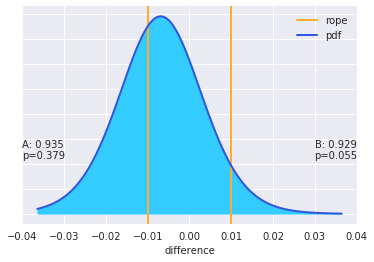

In [11]:
import baycomp
%matplotlib inline

names = ("A", "B") # A: 2NN, B: CNN
probs, plot = baycomp.two_on_single(accs_2NN, accs_CNN, runs=m_runs, rope=0.01, plot=True, names=names)

In [14]:
plot.savefig('./posterior.pdf', format='pdf')